Senator rows: 263
Stock rows:   2037471
✅ Event Study Samples: 1145


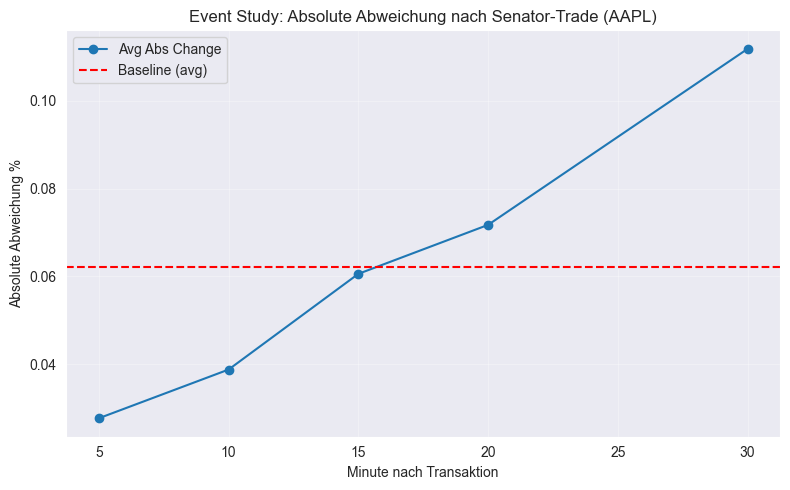

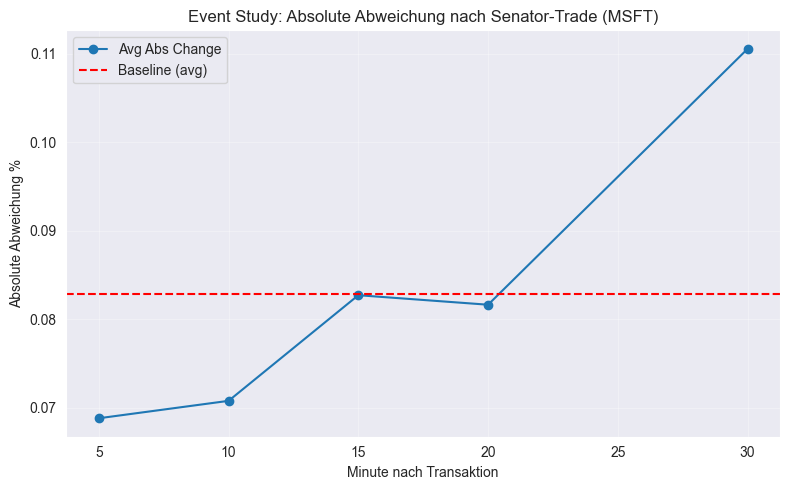

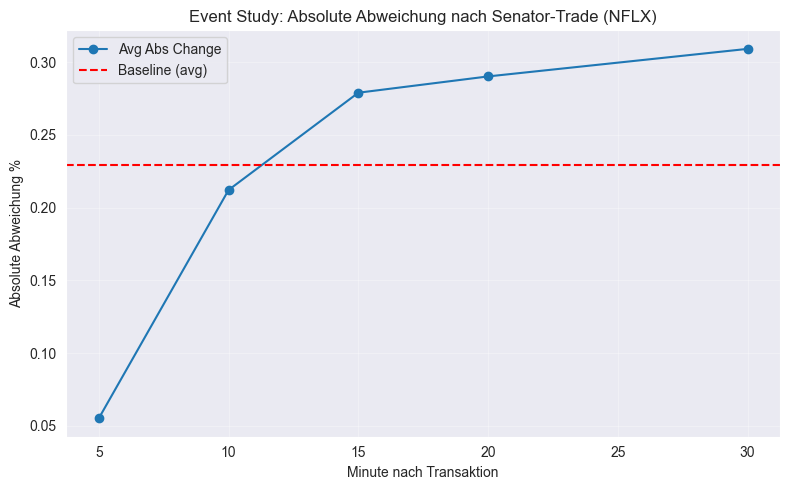

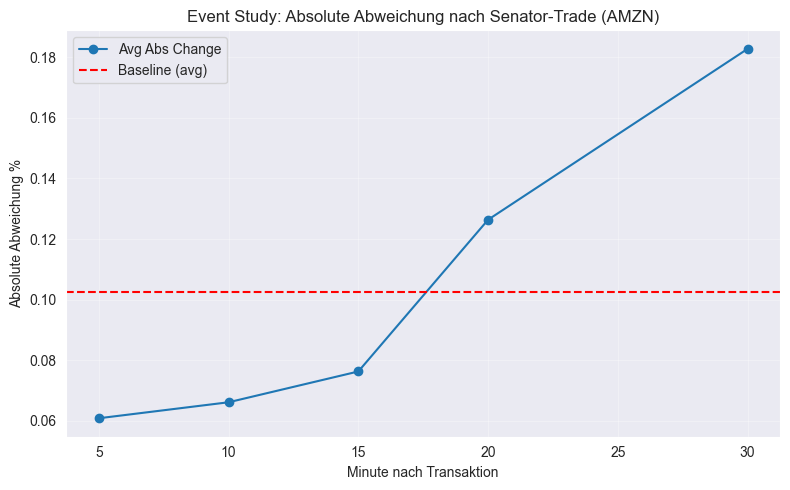

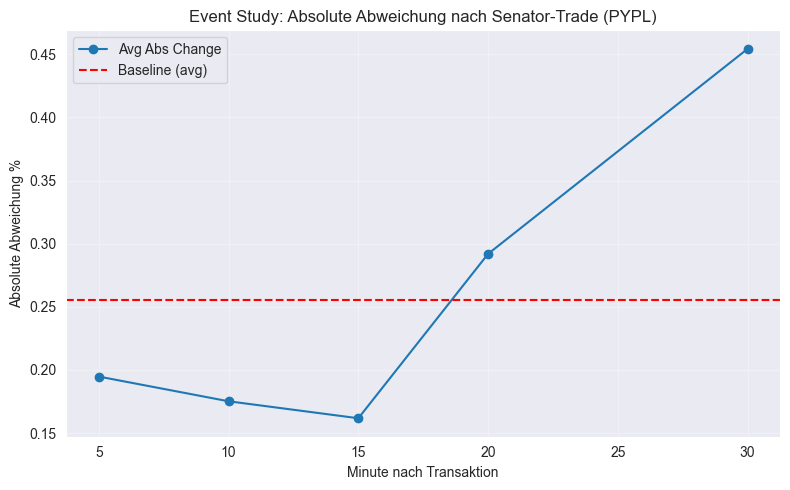

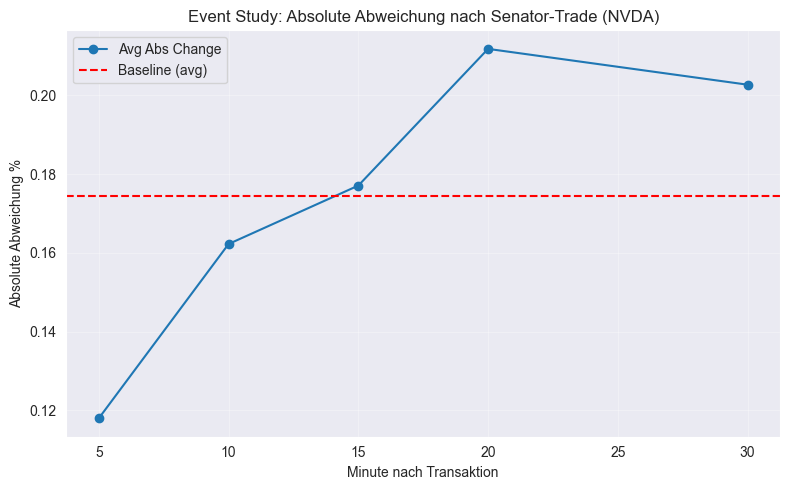

📁 Gespeichert: senator_event_study.parquet


In [4]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1. Daten laden
# =========================
sen_path = r"C:\Users\User\PycharmProjects\Project-Trading\data\merged_senator_transactions_2022_2025.csv"
stock_path = r"C:\Users\User\PycharmProjects\Project-Trading\data\stock_data.parquet"

df_sen = pd.read_csv(sen_path)
df_stock = pd.read_parquet(stock_path)

# =========================
# 2. Zeitstempel parsen
# =========================
df_sen['TimeOfFiled'] = pd.to_datetime(df_sen['TimeOfFiled'], errors='coerce')
df_stock['timestamp'] = pd.to_datetime(df_stock['timestamp'], errors='coerce')
df_sen['TimeOfFiled'] = df_sen['TimeOfFiled'].dt.tz_localize(None)
df_stock['timestamp'] = df_stock['timestamp'].dt.tz_localize(None)

# =========================
# 3. Relevante Ticker
# =========================
RELEVANT_TICKERS = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'PYPL', 'NVDA']
df_sen = df_sen[df_sen['ticker'].isin(RELEVANT_TICKERS)].copy()
df_stock = df_stock[df_stock['symbol'].isin(RELEVANT_TICKERS)].copy()

print(f"Senator rows: {len(df_sen)}")
print(f"Stock rows:   {len(df_stock)}")

# =========================
# 4. Senator-Features
# =========================
df_sen['signed_amount'] = df_sen['mean_amount']
df_sen['tx_hour'] = df_sen['TimeOfFiled'].dt.hour + df_sen['TimeOfFiled'].dt.minute / 60
df_sen['tx_weekday'] = df_sen['TimeOfFiled'].dt.weekday

# =========================
# 5. Event Study: mehrere Minuten & abs. Abweichung
# =========================
df_stock = df_stock.sort_values(['symbol', 'timestamp'])
minutes_list = [5, 10, 15, 20, 30]  # Zeitpunkte nach Veröffentlichung
results = []

for _, row in df_sen.iterrows():
    t = row['TimeOfFiled']
    ticker = row['ticker']

    # Kurs direkt nach Veröffentlichung
    current = df_stock[(df_stock['symbol'] == ticker) & (df_stock['timestamp'] >= t)].head(1)
    if current.empty:
        continue

    price_0 = current.iloc[0]['close']
    vol_0 = current.iloc[0]['volume']

    # Berechne absolute Abweichung für jede Minute
    for m in minutes_list:
        t_plus = t + timedelta(minutes=m)
        future = df_stock[(df_stock['symbol'] == ticker) & (df_stock['timestamp'] >= t_plus)].head(1)
        if future.empty:
            continue
        price_t = future.iloc[0]['close']
        vol_t = future.iloc[0]['volume']
        abs_change = abs(price_t - price_0) / price_0 * 100  # absolute Abweichung in %
        results.append({
            'TimeOfFiled': t,
            'Ticker': ticker,
            'minute': m,
            'signed_amount': row['signed_amount'],
            'tx_hour': row['tx_hour'],
            'tx_weekday': row['tx_weekday'],
            'price_before': price_0,
            'vol_before': vol_0,
            'vol_t': vol_t,
            'abs_change_pct': abs_change
        })

df_event = pd.DataFrame(results)
print(f"✅ Event Study Samples: {len(df_event)}")

# =========================
# 6. Baseline: durchschnittliche 30-Minuten-Abweichung pro Aktie
# =========================
baseline = df_event.groupby('Ticker')['abs_change_pct'].mean().reset_index()
baseline.rename(columns={'abs_change_pct': 'baseline_abs_change_pct'}, inplace=True)
df_event = df_event.merge(baseline, on='Ticker', how='left')

# =========================
# 7. Plots pro Aktie
# =========================
for ticker in RELEVANT_TICKERS:
    df_plot = df_event[df_event['Ticker'] == ticker]
    if df_plot.empty:
        continue

    avg_abs_change = df_plot.groupby('minute')['abs_change_pct'].mean()
    baseline_val = df_plot['baseline_abs_change_pct'].iloc[0]

    plt.figure(figsize=(8,5))
    plt.plot(avg_abs_change.index, avg_abs_change.values, marker='o', label='Avg Abs Change')
    plt.axhline(y=baseline_val, color='red', linestyle='--', label='Baseline (avg)')
    plt.title(f'Event Study: Absolute Abweichung nach Senator-Trade ({ticker})')
    plt.xlabel('Minute nach Transaktion')
    plt.ylabel('Absolute Abweichung %')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =========================
# 8. Ergebnis speichern
# =========================
df_event.to_parquet(
    r"C:\Users\User\PycharmProjects\Project-Trading\data\senator_event_study.parquet",
    index=False
)
print("📁 Gespeichert: senator_event_study.parquet")


In [2]:
import pandas as pd

path = r"C:\Users\User\PycharmProjects\Project-Trading\data\senator_stock_merged_fixed.parquet"

df = pd.read_parquet(path)

print(df.head())
print(df.info())


          TimeOfFiled Ticker  signed_amount    tx_hour  tx_weekday  \
0 2023-07-26 10:50:00   MSFT          32501  10.833333           2   
1 2023-07-26 10:50:00   PYPL          -8001  10.833333           2   
2 2021-08-11 08:49:00   MSFT          -8001   8.816667           2   
3 2022-01-12 15:10:00   PYPL         -32501  15.166667           2   
4 2022-01-12 15:10:00   AAPL         -75001  15.166667           2   

   price_before  vol_before  vwap_before  price_change_pct  
0        338.15   1566863.0       335.66          0.000000  
1         72.42    236301.0        72.60          0.000000  
2        325.33   1085870.0       324.45          0.000000  
3        187.62     38162.0       187.38         -0.698220  
4        173.32    376923.0       173.27         -0.467344  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 